# Gen proto

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import time
import sys
import os

if '..' not in sys.path: sys.path.append('..')

from src.utils.common import *
from src.utils.plot_utils import *
from src.dnd.actions import *
from src.dnd.units import *
from src.dnd.game_utils import *
from src.agent.agent import DnDAgent
from src.agent.deep_q_network import *
from src.agent.agent_utils import get_legal_action_resolver, get_states, agents_play_loop, agents_play_loop_bare
from src.agent.training import train_loop_sequential_V1, calculate_reward_classic_seq, train_loop_trivial, calculate_reward_classic
from src.dnd.game_configs import *
from src.dnd.game_board import GameState

In [11]:
seed_everything(1234, deterministic_cudnn=True)

In [12]:
def collate_fn(batch):
    # Unpack the batch into separate lists for each element in the tuple
    sts, actions, rewards, states_new, goals = zip(*batch)

    # Convert the lists to PyTorch tensors
    sts = torch.tensor(np.array(sts), dtype=torch.float32)
    states_new = torch.tensor(np.array(states_new), dtype=torch.float32)
    
    # Convert actions to a PyTorch tensor
    actions = torch.tensor(np.array(actions), dtype=torch.long)

    # Convert rewards to a PyTorch tensor
    rewards = torch.tensor(np.array(rewards), dtype=torch.float32)

    # Convert goals to a PyTorch tensor
    goals = torch.tensor(np.array(goals), dtype=torch.bool)

    # Return the collated batch
    return sts, actions, rewards, states_new, goals

## Sample agent game

In [13]:
# board_size, game_config = get_2v2_1_config()
# agent = DnDAgent(board_shape=board_size, in_channels=DnDBoard.STATE_CHANNEL_COUNT, out_actions=3, 
#     lr=1e-3, 
#     epsilon=0.9, 
#     min_epsilon=0.01,
#     epsilon_delta=1e-5, 
#     epsilon_strategy='exp',
#     gamma=0.9,
#     batch_size=32, 
#     dual_learning=True, 
#     replace_model_interval=15000,
#     memory_capacity=0,
#     random_action_resolver=get_legal_action_resolver(board_size, True),
#     model_class=DnDEvalModelRT5,
#     sequential_actions=True
# )
# 
# reset_agent = True
# winrate_threshold = 0.58
# game_iter_limit = 100
# train_loop = train_loop_sequential_V1
# reward_policy = calculate_reward_classic_seq

In [14]:
board_size, game_config = get_2v2_0_config()
agent = DnDAgent(board_shape=board_size, in_channels=DnDBoard.STATE_CHANNEL_COUNT, out_actions=2, 
    lr=1e-3, 
    epsilon=0.9, 
    min_epsilon=0.01,
    epsilon_delta=1e-5, 
    epsilon_strategy='linear',
    gamma=0.9,
    batch_size=32, 
    dual_learning=True, 
    replace_model_interval=5000,
    memory_capacity=0,
    random_action_resolver=get_legal_action_resolver(board_size, False),
    model_class=DnDEvalModelRT5,
    sequential_actions=False
)

winrate_threshold = 0.55
train_loop = train_loop_trivial
reward_policy = calculate_reward_classic

gens = 20
games = 1000
test_games = 250
test_iter_limit = 100
game_iter_limit = 200

In [15]:
average_result_over = 1000

# set to None to disable report / figures export
output_path = '../rnd/2v2-1/'
generation_name = 'overnight-1'
gen_header = \
'''# 

'''

In [16]:
iters, eps, gen_iters, winrates = [], [], [], []
mag1s, mag2s = [], []
memory = []

did_replace = [ False ]
def on_replace():
    global did_replace
    did_replace[0] = True

def memorize_external(states, actions, rewards, new_states, game_not_overs):
    memory.append((states, actions, rewards, new_states, not game_not_overs))

agent.on_replace = on_replace

current_agent = agent # this one will play games and fight the new agent
new_agent = None # this one will train on the gathered data and fight the current agent

report_results = output_path is not None
if report_results:
    gen_path = os.path.join(output_path, generation_name)
    os.makedirs(gen_path, exist_ok=generation_name.startswith('_temp'))
else: gen_path = '..' # so that checkpoints still work

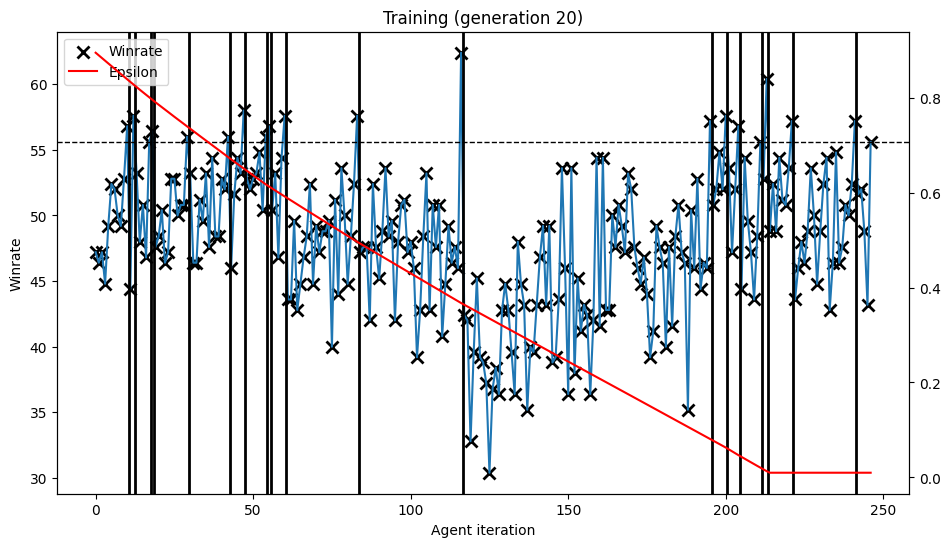

In [17]:
for generation in range(gens):
    avg = 0 if len(iters) == 0 else np.mean(iters[-average_result_over:]) # recent performance
    last_checkpoint_path = os.path.join(gen_path, f'gens/agent-gen{generation + 1}-{avg:0.1f}i')
    current_agent.save_agent(last_checkpoint_path)
    
    new_agent = DnDAgent.load_agent(last_checkpoint_path)
    new_agent.random_action_resolver = get_legal_action_resolver(board_size, new_agent.sequential_actions)
    new_agent.on_replace = on_replace

    iteration = 0

    while True:
        iteration += 1

        for i in range(games):
            game = generate_balanced_game(board_size, game_config)
            iter_count = train_loop(current_agent, game, reward_policy, iter_limit=game_iter_limit, do_learn=False, memorize_fn=memorize_external, raise_on_limit=False)
            iters.append(iter_count)

        dataloader = torch.utils.data.DataLoader(memory, batch_size=new_agent.batch_size, shuffle=True)
        for sample in dataloader:
             new_agent.learn(*sample)

        counter = []
        for i in range(test_games):
            game = generate_balanced_game(board_size, game_config)

            ic, win = agents_play_loop_bare(game, [new_agent, current_agent], [None, None], iter_limit=test_iter_limit)
            counter.append(win)

        winrate = np.sum(np.array(counter) == 0) / test_games
        winrates.append(winrate)
        eps.append(new_agent.epsilon)

        memory.clear()

        clear_output()
        plot_gen_history(winrates, gen_iters, eps)
        
        if winrate >= winrate_threshold: break
    
    gen_iters.append(iteration)
    current_agent = new_agent

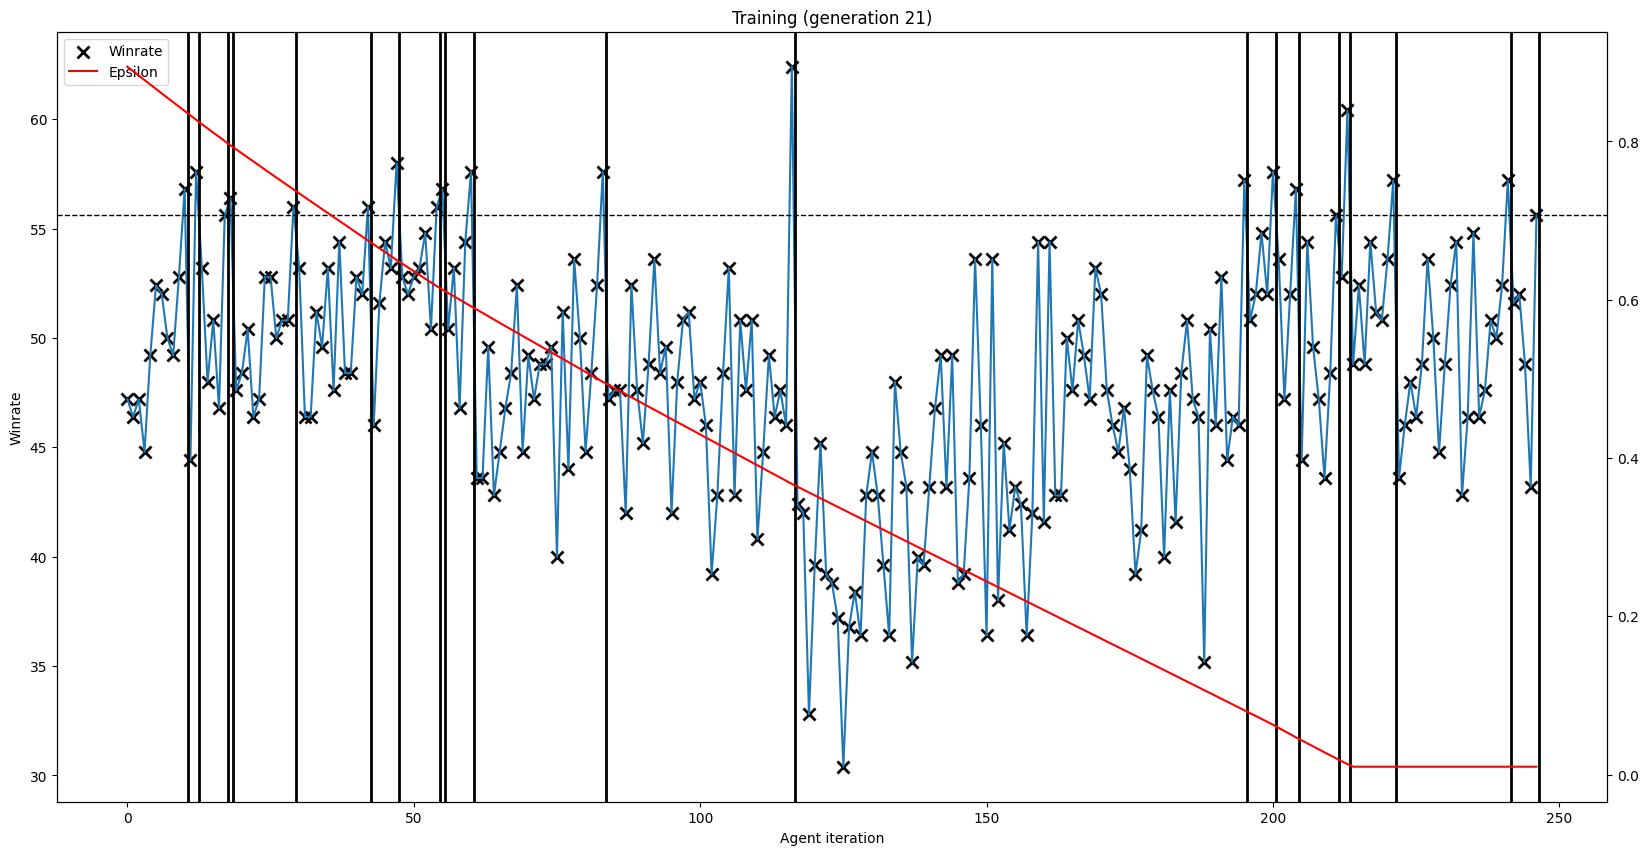

In [18]:
plot_gen_history(winrates, gen_iters, eps, figsize=(20, 10), show=False)
if report_results:
    plt.savefig(os.path.join(gen_path, 'training.png'), bbox_inches='tight')
plt.show()

In [19]:
if report_results:
    actual_games = len(iters)

    with open(os.path.join(gen_path, 'report.md'), 'w') as report:
        avg = np.mean(iters[-1000:])
        total = np.sum(iters)
        perf = 1e9 / (avg * total)
        report.write(
f'''{gen_header}
# Results
![image](training.png "")

* Average iteration count after {actual_games / 1000:0.1f}k games: {avg:0.2f}
* Total iterations performed: {total}
* Relative training performance: {perf:0.2f}
> 1e9 / (total_iter * avg_iter)

# Configuration

```python


games_played = {actual_games}
```
''')

In [20]:
print(f'Shortest game: {np.min(iters)}')
print(f'Longest game: {np.max(iters)}')
print(f'Number of shortest games: {np.sum(np.array(iters) == np.min(iters))}')

Shortest game: 4
Longest game: 200
Number of shortest games: 14


In [21]:
game, colormap = decorate_game(generate_balanced_game(board_size, game_config))

agents_play_loop(agent, agent, game, colormap, reset_epsilon=False, delay=1)

TypeError: object of type 'DnDAgent' has no len()

# Visualization

In [ ]:
game, colormap = decorate_game(generate_balanced_game(board_size, game_config))
print_game(game, colormap)

In [ ]:
state = game.observe_board()
plot_featuremaps(
    state, 
    title='Observed state', 
    fm_names=game.CHANNEL_NAMES,
    vmin = -3,
    vmax = 3,
    separate_cbars=True,
    cmap='Greens'
)

In [ ]:
state = game.observe_board()
output = agent.predict(state)

plot_featuremaps(
    output, 
    title='Agent output', 
    fm_names=['New coords', 'Target unit'],
    separate_cbars=True
)

print(agent.choose_action_vector(state))